*Nombre de Grupos*:

*Integrantes*:

# **Deteccion de Esquinas por el Algoritmo de Harris**


**Motivacion**: Extraer features robustas de una escena que podamos ubicar entre distintas imagenes.

Aunque las ventanas con bordes son mejores candidatos que una superficie homogenea, siguen siendo constante en una direccion, haciendolas dificil de usar para ubicar.

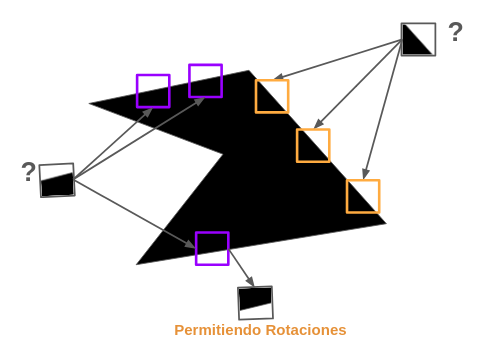


Por otro lado, las esquinas al tener dos direcciones de cambio son mucho mas robustas.

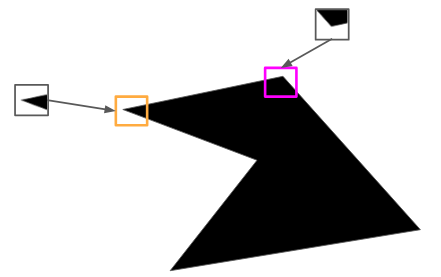




##Configuracion

In [ ]:
from scipy import ndimage
from skimage import filters
from skimage import util
import skimage.io as io
from skimage import feature
from skimage import img_as_ubyte
from skimage import img_as_float

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import os

##**Ejemplo de Harrys.**

###Calculo de Derivada con Sobel Y Gauss

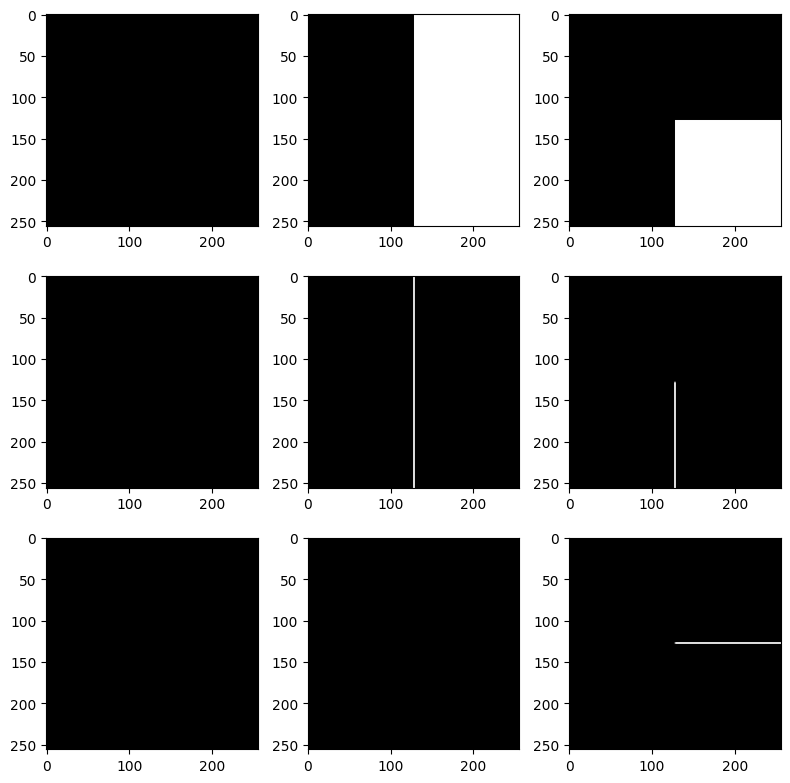

In [ ]:
#Creamos las 3 posibles tipos de Imagen
imagenConstante = np.zeros((256, 256))

imagenBorde = np.zeros((256, 256))
imagenBorde[:, 128:] = 1

imagenEsquina = np.zeros((256, 256))
imagenEsquina[128:, 128:] = 1

#Calculamos la derivada parcial de cada una
derivadaConstanteY = filters.sobel_h(imagenConstante)
derivadaConstanteX = filters.sobel_v(imagenConstante)

derivadaBordeY = filters.sobel_h(imagenBorde)
derivadaBordeX = filters.sobel_v(imagenBorde)

derivadaEsquinaY = filters.sobel_h(imagenEsquina)
derivadaEsquinaX = filters.sobel_v(imagenEsquina)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(imagenConstante, cmap=plt.cm.gray)
ax[1].imshow(imagenBorde, cmap=plt.cm.gray)
ax[2].imshow(imagenEsquina, cmap=plt.cm.gray)


ax[3].imshow(img_as_ubyte(derivadaConstanteX), cmap=plt.cm.gray)
ax[4].imshow(img_as_ubyte(derivadaBordeX), cmap=plt.cm.gray)
ax[5].imshow(img_as_ubyte(derivadaEsquinaX), cmap=plt.cm.gray)


ax[6].imshow(img_as_ubyte(derivadaConstanteY), cmap=plt.cm.gray)
ax[7].imshow(img_as_ubyte(derivadaBordeY), cmap=plt.cm.gray)
ax[8].imshow(img_as_ubyte(derivadaEsquinaY), cmap=plt.cm.gray)

plt.tight_layout()
plt.show()

### Construimos las Imagenes Necesarias

In [ ]:
#Calculamos cada una de las derivadas a cuadrado
derivadaEsquinaYDoble = derivadaEsquinaY**2
derivadaEsquinaXDoble = derivadaEsquinaX**2
derivadaEsquinaXY = derivadaEsquinaY * derivadaEsquinaX

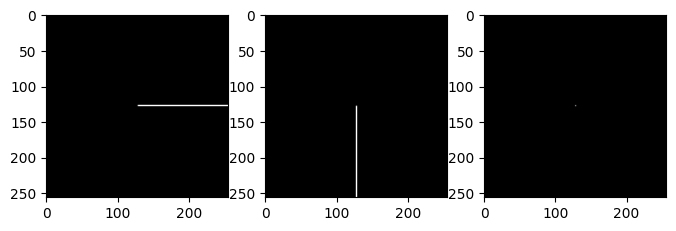

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8, 8))
ax = axes.ravel()

#Ploteamos cada una de estas derivadas, notemos como hay un unico punto en derivadaEsquinaXY
ax[0].imshow(derivadaEsquinaYDoble, cmap=plt.cm.gray)
ax[1].imshow(derivadaEsquinaXDoble, cmap=plt.cm.gray)
ax[2].imshow(derivadaEsquinaXY, cmap=plt.cm.gray)
plt.show()

### Construimos la Matriz M

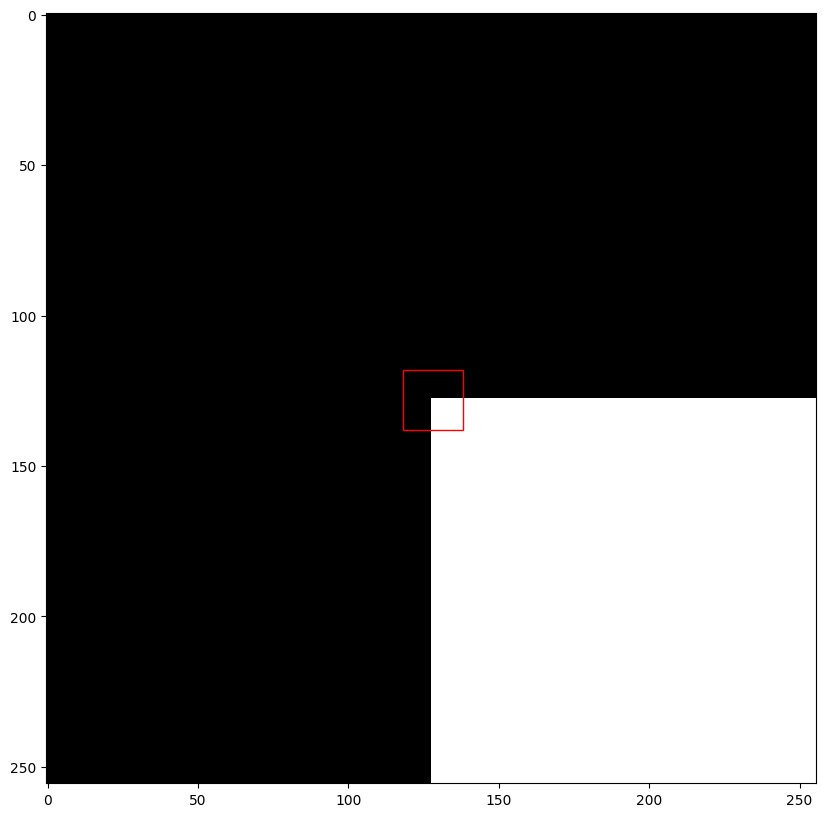


Matriz gradiante de la ventana centrada en (128, 128) de tamano 20: 
 [[19.25  1.  ]
 [ 1.   19.25]]


In [ ]:
#Definimos el tamano de la ventana
VentanaShape = 20
mitad = VentanaShape//2

#Definimos en donde se centrara la ventana (y,x)
Centro = (128,128)

# Create a Rectangle patch
fig, ax = plt.subplots(1,figsize=(10, 10))

rect = patches.Rectangle((Centro[1]-VentanaShape/2, Centro[0]-VentanaShape/2), VentanaShape, VentanaShape, linewidth=1, edgecolor='r', facecolor='none')
ax.imshow(imagenEsquina, cmap=plt.cm.gray)
ax.add_patch(rect)

plt.show()


#Tomamos la derivada X, Y y XY de la ventana
MatrizM_X = np.sum(derivadaEsquinaXDoble[Centro[1]-mitad:Centro[1]+mitad,
                                         Centro[0]-mitad:Centro[0]+mitad])

MatrizM_Y = np.sum(derivadaEsquinaYDoble[Centro[1]-mitad:Centro[1]+mitad,
                                         Centro[0]-mitad:Centro[0]+mitad])

MatrizM_XY = np.sum(derivadaEsquinaXY[Centro[1]-mitad:Centro[1]+mitad,
                                         Centro[0]-mitad:Centro[0]+mitad])

#Creamos la Matriz M
M = [[MatrizM_X,MatrizM_XY],[MatrizM_XY,MatrizM_Y]]
MatrizM = np.asarray(M)

print()
print(f"Matriz gradiante de la ventana centrada en {Centro} de tamano {VentanaShape}: \n {MatrizM}")

### Calculamos su "esquinidad"

In [ ]:
R = np.linalg.det(MatrizM) - 0.4 * np.trace(MatrizM)
print(R)

354.1625000000003


# **Histogram of Oriented Gradients (HOG)**

El descriptor **HOG (Histogram of Oriented Gradients)** es una técnica ampliamente utilizada para la **detección de objetos**. Captura la estructura o forma de los objetos a través de la distribución de gradientes de intensidad.



## **¿Qué es HOG?**

La idea principal de HOG es que la **apariencia local** y la **forma** de los objetos pueden describirse bien mediante la distribución de **gradientes** (cambios de intensidad) u **orientaciones de bordes**.


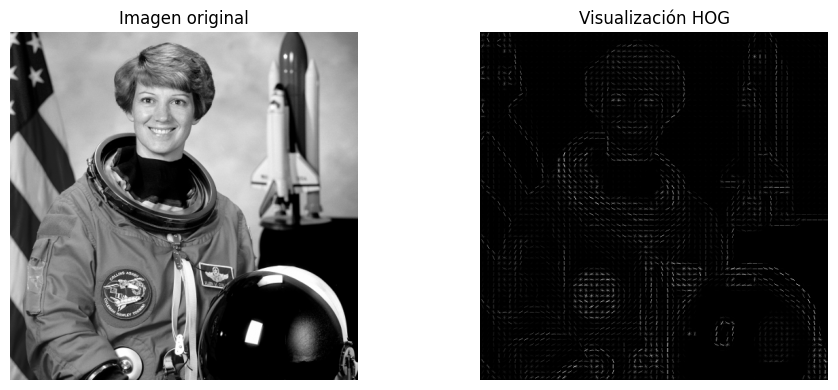

In [ ]:
from skimage import data, color
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# Cargar imagen de ejemplo en escala de grises
image = color.rgb2gray(data.astronaut())

# Calcular HOG y su visualización
# Usameremos 9 orientaciones, celdas de 8x8 y bloques de 2x2 celdas para la
# normalizacion L2-Hys.
features, hog_image = hog(image,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys',
                          visualize=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(image, cmap='gray')
axs[0].set_title('Imagen original')
axs[0].axis('off')

axs[1].imshow(hog_image, cmap='gray')
axs[1].set_title('Visualización HOG')
axs[1].axis('off')

fig.tight_layout()
plt.show()

In [ ]:
print(f'Vector de características HOG: {features.shape}')
print(features)

Vector de características HOG: (142884,)
[0.34716709 0.13619803 0.         ... 0.12257368 0.18558105 0.06076373]


## ¿Por qué no usar una distribución global?

Una distribución global pierde toda la información espacial. Dos imágenes con estructuras muy distintas pueden tener la misma distribución de bordes global.

## **Como calculamos HOG?**:

1. **Preprocesamiento**: Normalización de la imagen (por ejemplo, conversión a escala de grises).
2. **Cálculo de gradientes**: Se usa Sobel o alguna máscara similar.
3. **Celdas**: Dividimos la imagen en pequeñas celdas (por ejemplo, 8x8 píxeles).
4. **Histogramas**: Para cada celda, computamos un histograma de direcciones de gradiente.
5. **Bloques**: Agrupamos celdas en bloques más grandes (por ejemplo, 2x2 celdas), y normalizamos.
6. **Vector final**: Concatenamos todos los histogramas normalizados.


## ***Ejercicio Implementacion: Implementación de HOG***

> Utilizaremos imágenes en escala de grises de tamaño fijo **80x120** píxeles. Para ello, seleccionaremos un recorte o reescalaremos imágenes previamente cargadas.


### **Paso 1: Cargar y preparar la imagen**

> Usaremos la imagen de **Chelsea** (un gato) como ejemplo durante el ejercico. Primero la cargaremos, la pasaremos a escala de grises, y luego la transformaremos a dimensiones **(80, 120)**.



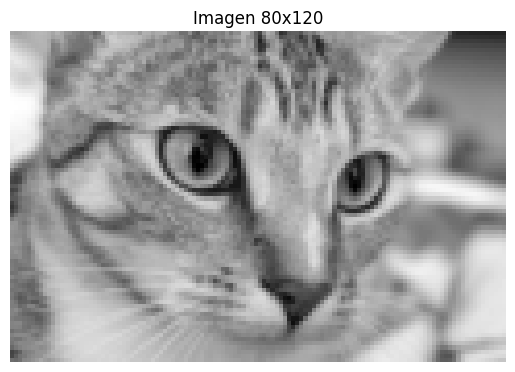

In [ ]:
from skimage import data, color, transform
import matplotlib.pyplot as plt

# Cargar imagen RGB y convertir a escala de grises
image = data.chelsea()  # imagen de un gato
gray = color.rgb2gray(image)

# Reescalar a tamaño fijo (80x120)
resized = transform.resize(gray, (80, 120), anti_aliasing=True)

fig, ax = plt.subplots()
ax.imshow(resized, cmap='gray')
ax.set_title('Imagen 80x120')
ax.axis('off')
plt.show()

### **Paso 2: Calcular los gradientes**

***Ejercicio:*** Implementar el cálculo de gradientes en x e y usando filtros Sobel

> Aplicar los filtros de Sobel para calcular los gradientes en las direcciones horizontal (Gx) y vertical (Gy). Obtener Magnitud y orientacion

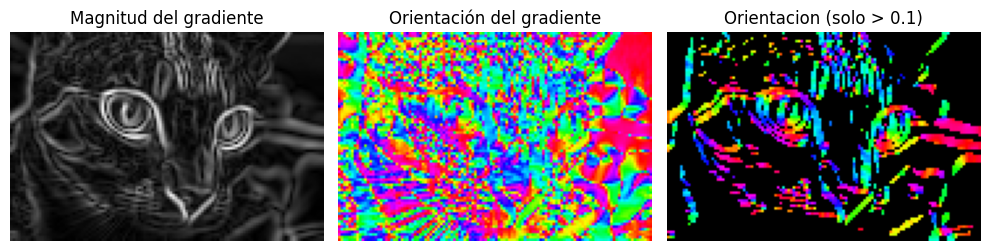

In [ ]:
import numpy as np
from scipy import ndimage
from skimage.filters import sobel_h, sobel_v

def obtener_mag_y_orientacion(img):
  # Calcular gradientes
  Gx = sobel_h(img)
  Gy = sobel_v(img)

  # Magnitud y ángulo
  magnitude = np.sqrt(Gx**2 + Gy**2)
  orientation = np.arctan2(Gy, Gx)

  # convertimos los ángulos en [0,180)
  orientation = orientation * (180 / np.pi) % 180

  return magnitude, orientation


magnitude, orientation = obtener_mag_y_orientacion(resized)

# Umbral para magnitud
THRESHOLD = 0.1

# Máscara: mantener solo orientaciones con magnitud suficiente
# SOLO PARA FINES VISUALES
orientation_masked = np.where(magnitude > THRESHOLD, orientation, np.nan)

hsv_cmap = plt.get_cmap('hsv').copy()
hsv_cmap.set_bad(color='black')

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Mostrar magnitud y orientación
axs[0].imshow(magnitude, cmap='gray')
axs[0].set_title('Magnitud del gradiente')
axs[0].axis('off')

axs[1].imshow(orientation, cmap='hsv')
axs[1].set_title('Orientación del gradiente')
axs[1].axis('off')

axs[2].imshow(orientation_masked, cmap=hsv_cmap)
axs[2].set_title(f'Orientacion (solo > {THRESHOLD})')
axs[2].axis('off')

plt.tight_layout()
plt.show()


### **Paso 3: Construir histogramas de orientación**

**Ejercicio:** Dividir la imagen en celdas y calcular histogramas de orientación

> Dividir la imagen en celdas de 8x8 píxeles y calcular un histograma de 9 bins para las orientaciones, realizar la votacion por la magnitud del gradiente.

In [ ]:
# Dado la magnitud y orientacion de cada pixel, el tamaño de las celdas y la cantidad
# de orientaciones, calcula el histograma de orientacion para cada celda.

def computarHistogramaDeCeldas(magnitud, orientacion, cell_size=8, orentacion_bins=9):

  # Podemos suponer que las dimensiones de la imagen sera multiplo de las
  # dimensiones de la celdas.

  # Dividimos la imagen en celdas
  height, width = magnitud.shape
  n_cells_y = height // cell_size
  n_cells_x = width // cell_size

  # Creamos un histograma vacio
  histograms = np.zeros((n_cells_y, n_cells_x, orentacion_bins))

  # Calculamos el ancho de los bind de angulos
  bin_width = 180 // orentacion_bins

  # Calculamos el histograma de cada celda
  for i in range(n_cells_y):
    for j in range(n_cells_x):

      # Calculamos que pixeles formaran parte de la celda
      celda_pixeles_r =(i*cell_size, (i+1)*cell_size)
      celda_pixeles_c =(j*cell_size, (j+1)*cell_size)

      mag_block = magnitud[celda_pixeles_r[0] : celda_pixeles_r[1], celda_pixeles_c[0] : celda_pixeles_c[1]]
      ang_block = orientacion[celda_pixeles_r[0] : celda_pixeles_r[1], celda_pixeles_c[0] : celda_pixeles_c[1]]

      hist = np.zeros(orentacion_bins)

      # COMPLETAR...
      # Por cada pixel de la celda, encontramos su bin correspondiente y
      # agregamos su magnitud al histograma
      for row in range(mag_block.shape[0]):
        for col in range(mag_block.shape[1]):
          angle = ang_block[row, col]
          bin_index = round(angle // bin_width) - 1
          hist[bin_index] += mag_block[row, col]

      histograms[i, j] = hist

  return histograms

cell_histograms = computarHistogramaDeCeldas(magnitude, orientation)
print("Forma del array de histogramas por celda:", cell_histograms.shape)

Forma del array de histogramas por celda: (10, 15, 9)


#### Visualizar HOG
> Podemos representar la orientación dominante de cada celda con una línea cuya longitud esté ponderada por la magnitud acumulada en esa dirección.


In [ ]:
from skimage import draw

def visualize_hog_field(cell_histograms, cell_size=8, bins=9, scale=0.4):

  n_cells_row, n_cells_col, _ = cell_histograms.shape

  s_row = n_cells_row * cell_size
  s_col = n_cells_col * cell_size

  hog_image = np.zeros((s_row, s_col), dtype=np.float32)

  # Parámetros de dibujo
  c_row, c_col = cell_size, cell_size
  radius = cell_size // 2 - 1
  orientations_arr = np.arange(bins)
  orientation_bin_midpoints = np.pi * (orientations_arr + 0.5) / 9

  dr_arr = radius * np.sin(orientation_bin_midpoints)
  dc_arr = radius * np.cos(orientation_bin_midpoints)

  # Dibujar líneas por celda y bin
  for r in range(n_cells_row):
    for c in range(n_cells_col):
      for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
        center_r = r * c_row + c_row // 2
        center_c = c * c_col + c_col // 2
        rr, cc = draw.line(
            int(center_r - dc),
            int(center_c + dr),
            int(center_r + dc),
            int(center_c - dr)
        )

        # Acumular intensidad del bin en esa celda
        hog_image[rr, cc] += cell_histograms[r, c, o]

  # Normalizar para visualización
  hog_image /= hog_image.max()

  return hog_image


#### Comparacion Con Scikit Image

/tmp/ipython-input-513351025.py:38: RuntimeWarning: invalid value encountered in divide
  hog_image /= hog_image.max()


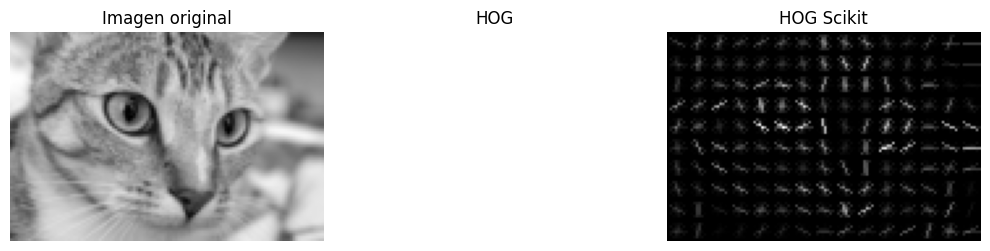

In [ ]:

hogImage = visualize_hog_field(cell_histograms, cell_size=8, bins=9)

_, hogimageScikit = hog(resized,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys',
                          visualize=True)

fig, ax = plt.subplots(1,3,figsize=(10, 4))

ax[0].imshow(resized, cmap='gray')
ax[0].set_title('Imagen original')
ax[0].axis('off')

ax[1].set_facecolor('black')
ax[1].imshow(hogImage, cmap='gray')
ax[1].set_title('HOG')
ax[1].axis('off')

ax[2].imshow(hogimageScikit, cmap='gray')
ax[2].set_title('HOG Scikit')
ax[2].axis('off')

fig.tight_layout()
plt.show()



### **Paso 4: Normalización por bloques**

**Ejercicio**: Normalizar los histogramas por bloques 2x2 celdas

> Aplicar normalización L2 sobre bloques de 2x2 celdas contiguas para obtener invariancia a iluminación y contraste.

In [ ]:
def normalizarBloques(cell_histograms, block_size=2):

  n_cells_y, n_cells_x, bins = cell_histograms.shape

  n_blocks_y = n_cells_y - block_size + 1
  n_blocks_x = n_cells_x - block_size + 1

  features = []

  # Por cada uno de los bloques, encontramos sus celdas y normalizamos
  for i in range(n_blocks_y):
    for j in range(n_blocks_x):
      # Encontramos su celda y las concatenamos
      block = cell_histograms[i:i+block_size, j:j+block_size].ravel()
      # COMPLETAR...
      # Calcular la norma del vector con los histogramas del bloque
      norm = np.linalg.norm(block)
      # Normalizar el vector por esta norma
      block /= norm
      # Lo agregamos al vector de features de la imagen
      features.append(block)

  return np.concatenate(features)

hog_features = normalizarBloques(cell_histograms)

print("Tamaño del vector HOG final:", hog_features.shape)

Tamaño del vector HOG final: (4536,)


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm




---



# **Detector de Peatones con HOG + SVM**

Con HOG ya implementado, ahora lo utilizaran para crear un detector de peatones en imagenes. Para esto necesitaran entrenar una SVM con los descriptores de HOG para poder clasificar secciones de una imagen entre si contienen un peaton o no lo hacen. Como dataset de entrenamiento utilizaran [`INRIA Person Dataset`](https://drive.google.com/drive/folders/1kkfgEW5W4pLgty7gzGhwQ0p5IDiwe2GC?usp=sharing)

La implementacion estara fuertemente basada en el siguiente paper: [**Histograms of Oriented Gradients for Human Detection**](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf)

### **SVM**

Un SVM (Support Vector Machine) es un clasificador supervisado que encuentra el mejor hiperplano que separa dos clases, es decir, el que obtenga la mayor distancia (margen) entre los puntos de categorias diferentes mas cercanos.

El hiperplano deberia cumplir:

- $x$ es de clase $ 1⇒ w^Tx+b ≥ 1$

- $x$ es de clase $ 0⇒ w^Tx+b ≤ 0$

donde $w$ es el vector normal al hiperplano y b su offset.

Para predecir en nuevas entradas haremos:

- $w^Tx+b > 0 ⇒ $ $x$ es de clase 1

- $w^Tx+b < 0 ⇒ $ $x$ es de clase 0

Aunque no este en el scope de la materia, pueden encontrar mas informacion sobre svm en: [Support Vector Machines, Main Ideas](https://www.youtube.com/watch?v=efR1C6CvhmE) y [Understanding the mathematics behind Support Vector Machines](https://shuzhanfan.github.io/2018/05/understanding-mathematics-behind-support-vector-machines/)

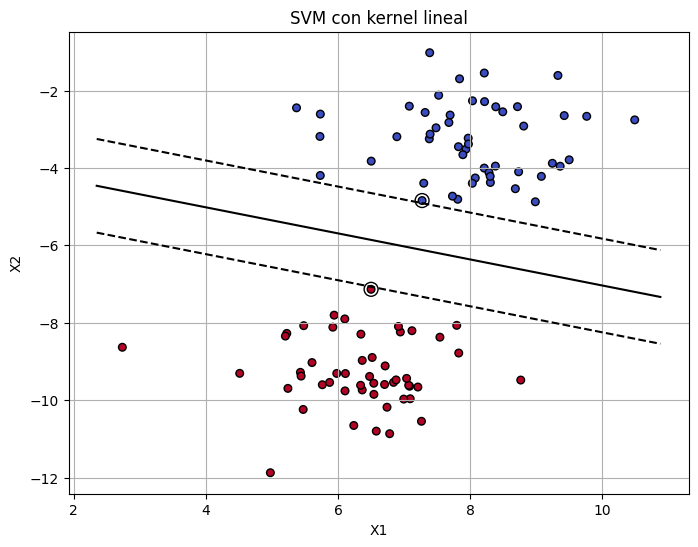

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

# Generamos datos sintéticos: dos clases separables
X, y = make_blobs(n_samples=100, centers=2, random_state=6)

# Creamos un clasificador SVM lineal
# El kernel es la forma en la que transformaremos los datos de entrada
# para hacer posible el separarlos con un hiperplano.
# Por ser el computacionalmente mas barato, en este trabajo usaremos el kernel lineal.
clf = SVC(kernel='linear')

# Entrenamos el categorizador, X siendo los datos de entrada y Y el vector con
# la categorias correspondientes (0, 1)
clf.fit(X, y)

# Visualizamos los datos
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, edgecolors='k')

# Dibujamos la línea de decisión, el hiperplano
# si el producto punto entre el vector de entrada y el hiperplano es mayora a 1,
# entonces sera categoria 1. Si el producto en menor a -1, sera categoria 0.
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Crear malla para graficar la recta de decisión
xx = np.linspace(xlim[0], xlim[1], 30)
w = clf.coef_[0] # Vector normal
b = clf.intercept_[0] # offset
yy = -(w[0] * xx + b) / w[1]

# Dibujar márgenes
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_plus = yy + margin
yy_minus = yy - margin

plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_plus, 'k--')
plt.plot(xx, yy_minus, 'k--')

# Dibujar los vectores de soporte
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=100, linewidth=1, facecolors='none', edgecolors='k')

plt.title("SVM con kernel lineal")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()

In [ ]:
new_point = np.array([[3, 5]])

# Hacer predicción
pred = clf.predict(new_point)[0]
print(f"El modelo predice la clase: {pred}")

El modelo predice la clase: 0




---



### ***Ejercicio***: Recolectar los descriptores de HOG y utilizarlos para entrenar una SVM

In [ ]:
import os
import numpy as np
from skimage import io, color
from skimage.feature import hog
from sklearn.utils import shuffle
import joblib
from sklearn import svm


def read_filenames(pos_img_dir, neg_img_dir):
    """
    Lee los nombres de archivos de las carpetas de imágenes positivas y negativas.
    """
    f_pos = sorted([f for f in os.listdir(pos_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    f_neg = sorted([f for f in os.listdir(neg_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return f_pos, f_neg

In [ ]:
def crop_centre(img, target_size=(120, 80)):
    h, w = img.shape[:2]
    th, tw = target_size
    start_y = (h - th) // 2
    start_x = (w - tw) // 2
    return img[start_y:start_y + th, start_x:start_x + tw]

def ten_random_windows(image, window_size=(120, 80), num_windows=10):
    h, w = image.shape
    win_h, win_w = window_size
    windows = []

    for _ in range(num_windows):
        y = np.random.randint(0, h - win_h)
        x = np.random.randint(0, w - win_w)
        window = image[y:y + win_h, x:x + win_w]
        windows.append(window)

    return windows

In [ ]:
def aplicar_hog(img):
  mag, ori = obtener_mag_y_orientacion(img)
  cell_hists = computarHistogramaDeCeldas(mag, ori)
  vector_hog = normalizarBloques(cell_hists)
  return vector_hog

In [ ]:
def read_images(pos_files, neg_files, pos_img_dir, neg_img_dir):
    """
    Lee imágenes positivas y negativas, extrae características HOG y asigna etiquetas.
    """
    X = [] # Vector de datos de entrada
    Y = [] # Vector de clases correspondientes

    pos_count = 0
    neg_count = 0

    # Proceso imágenes positivas
    for img_file in pos_files:
        path = os.path.join(pos_img_dir, img_file)
        print(f"Leyendo positivo: {path}")
        img = io.imread(path)
        gray = color.rgb2gray(crop_centre(img))

        # COMPLETAR...
        #  Recolectar Hog y agregar su Label Correspondiente en X, Y
        hog_features = aplicar_hog(gray)

        X.append(hog_features)
        Y.append(1)

        pos_count += 1

    # Proceso imágenes negativas (varias ventanas por imagen)
    for img_file in neg_files:
        path = os.path.join(neg_img_dir, img_file)
        print(f"Leyendo negativo: {path}")
        img = io.imread(path)
        gray = color.rgb2gray(img)

        windows = ten_random_windows(gray)  # Esta debe devolver una lista de regiones 80x120

        for win in windows:
            # COMPLETAR...
            #  Recolectar Hog y agregar su Label Correspondiente en X, Y
            hog_features = aplicar_hog(win)

            X.append(hog_features)
            Y.append(0)

            neg_count += 1

    return np.array(X), np.array(Y), pos_count, neg_count

### **Entrenamiento**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pos_img_dir = '/content/drive/MyDrive/Peatones/DataSet/Train/pos'
neg_img_dir = '/content/drive/MyDrive/Peatones/DataSet/Train/neg'

# Leer archivos
pos_img_files, neg_img_files = read_filenames(pos_img_dir, neg_img_dir)

print(f"Total Positive Images: {len(pos_img_files)}")
print(f"Total Negative Images: {len(neg_img_files)}")
print("Leyendo imágenes...")

# Leer y procesar imágenes
X, Y, pos_count, neg_count = read_images(pos_img_files, neg_img_files, pos_img_dir, neg_img_dir)

# Convertir a arrays numpy y mezclar
X = np.array(X)
Y = np.array(Y)
X, Y = shuffle(X, Y, random_state=0)

print("Imágenes leídas y mezcladas")
print(f"Positivos: {pos_count}")
print(f"Negativos: {neg_count}")
print("Entrenando clasificador ...")

# Entrenamiento con LinearSVC
clf1 = svm.LinearSVC(C=0.01, max_iter=1000, class_weight='balanced', verbose=1)
clf1.fit(X, Y)

print("Clasificador entrenado. Guardando...")
joblib.dump(clf1, 'person_preliminary.pkl') # RECUERDEN ENTREGAR ESTO

Total Positive Images: 2188
Total Negative Images: 1198
Leyendo imágenes...
Leyendo positivo: /content/drive/MyDrive/Peatones/DataSet/Train/pos/crop001001a.png
Leyendo positivo: /content/drive/MyDrive/Peatones/DataSet/Train/pos/crop001001b.png
Leyendo positivo: /content/drive/MyDrive/Peatones/DataSet/Train/pos/crop001001c.png
Leyendo positivo: /content/drive/MyDrive/Peatones/DataSet/Train/pos/crop001001d.png
Leyendo positivo: /content/drive/MyDrive/Peatones/DataSet/Train/pos/crop001001e.png
Leyendo positivo: /content/drive/MyDrive/Peatones/DataSet/Train/pos/crop001001f.png
Leyendo positivo: /content/drive/MyDrive/Peatones/DataSet/Train/pos/crop001002a.png
Leyendo positivo: /content/drive/MyDrive/Peatones/DataSet/Train/pos/crop001002b.png
Leyendo positivo: /content/drive/MyDrive/Peatones/DataSet/Train/pos/crop001002c.png
Leyendo positivo: /content/drive/MyDrive/Peatones/DataSet/Train/pos/crop001002d.png
Leyendo positivo: /content/drive/MyDrive/Peatones/DataSet/Train/pos/crop001003a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000003a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000004a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000005a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000006a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000010a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000011a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000012a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000014a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000015a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000030a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000033a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000051a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000052a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000053a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000054a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000055a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000056a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000057a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000058a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000060a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000061a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000062a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000068a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000070a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000083a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000089a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000090a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000091a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000092a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000093a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000094a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000095a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000098a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000099a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000100a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000101a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000102a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000103a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000104a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000105a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000106a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000107a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000108a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000109a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000125a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000126a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000127a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000128a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000129a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000130a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000131a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000132a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000133a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000134a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000135a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000136a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000138a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000139a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000140a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000141a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000142a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000143a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000144a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000145a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000146a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000147a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000148a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000149a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000150a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000151a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000152a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000153a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000154a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000155a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000157a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000158a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000159a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000160a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000162a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000164a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000165a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000166a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000167a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000168a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000169a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000170a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000172a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000173a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000175a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000176a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000206a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000208a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000210a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000211a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000212a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000213a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000214a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000215a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000217a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000218a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000219a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000220a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000221a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000222a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000223a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000231a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000232a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000233a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000234a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000235a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000236a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000237a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000238a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000239a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000240a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000264a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000265a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000266a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000267a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000272a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000274a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000275a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000276a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000277a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000278a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000280a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000281a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000282a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000283a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000284a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000285a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000286a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000295a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000299a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000300a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000303a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000305a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000306a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000307a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000308a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000309a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000310a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000311a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000312a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000333a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000334a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000335a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000336a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000338a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000340a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000341a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000342a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000343a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000344a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000345a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000365a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000414a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000415a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000416a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000420a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000421a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000422a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000423a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000424a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000425a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000426a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000427a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000428a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000581a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000582a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000583a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000584a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000585a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000586a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000587a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000588a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000589a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000590a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm
/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000591a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000592a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000593a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000594a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000595a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000596a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000597a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000598a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000599a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000600a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000601a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000602a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm
/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000603a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000604a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000605a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000609a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000610a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000611a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000613a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000617a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000618a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000622a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000623a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000624a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000628a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000632a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000636a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000638a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000639a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000640a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000644a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000647a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000649a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000650a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000651a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000653a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000656a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000658a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000660a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000661a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000662a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000663a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000665a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000666a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000667a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000668a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000669a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000670a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000671a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000672a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000673a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000674a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000675a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000676a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000677a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000678a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000679a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000680a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000681a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000682a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000683a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000685a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000686a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000687a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000692a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000693a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000706a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000726a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000727a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000729a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000737a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000738a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000740a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000741a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000742a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000743a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000744a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000747a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000748a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000752a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000754a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000755a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000756a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000757a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000758a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000759a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000760a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000763a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000764a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000765a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000767a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000769a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000770a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000771a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000775a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000776a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000777a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000778a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000779a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000780a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000781a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000782a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000783a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000784a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000785a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000786a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000793a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000794a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000795a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000796a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000797a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000798a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm
/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000799a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000800a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000801a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000802a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000804a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000806a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000807a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000808a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000809a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000810a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000811a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000812a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000827a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000829a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000830a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000831a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000832a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000833a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000834a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000835a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000836a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000837a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000838a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000840a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000873a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000874a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000875a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000876a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000880a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000881a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000882a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000883a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000884a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000885a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000886a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000887a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000888a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000889a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000890a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000891a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000897a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000904a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000907a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000910a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000912a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000914a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000918a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000922a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000923a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000926a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000927a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000928a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000930a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm
/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000935a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000936a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000939a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000940a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000941a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000942a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000943a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000948a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000951a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000952a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000955a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000956a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000957a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000958a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000959a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000960a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000961a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000962a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000963a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000964a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000965a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00000966a.png
Leyendo negativo

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm
/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001060a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001061a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001064a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001065a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001066a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001067a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001068a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001069a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001070a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001073a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001075a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001076a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001077a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001078a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001081a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001082a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001083a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001084a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001086a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001089a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001090a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001091a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm
/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001092a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001094a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001096a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001097a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001100a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001104a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001105a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001106a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001107a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001108a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001111a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001112a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001113a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001114a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001116a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001118a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001119a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001120a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001121a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001122a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001123a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001124a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001125a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001126a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001127a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001129a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001130a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001131a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001132a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001133a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001134a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001135a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001136a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001140a.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/00001145a.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/01-03d.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/01-03e.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/02-03k.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/02-03n.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-01-03_17h32m06s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-01-04_14h39m04s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-01-05_16h14m24s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-01-24_14h22m51s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-02-01_11h30m08s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-03-04_11h07m17s.jpg
Leyendo negativo: /content/drive/MyDri

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-04-11_12h38m50s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-04-11_13h07m53s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-04-11_13h54m43s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-04-11_13h55m02s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-04-11_14h02m06s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-04-11_14h02m28s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-04-25_09h32m56s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-04-25_10h01m52s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-04-25_12h04m49s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-04-25_12h58m29s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-04-25_14h59m59s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-08_10h25m24s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Tr

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-10_18h08m37s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-11_18h31m47s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-11_18h32m12s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-11_21h29m40s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-11_21h31m05s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-12_17h53m15s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-12_18h05m19s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-12_18h08m02s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-13_12h48m47s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-14_13h27m27s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-14_13h41m53s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-14_19h40m06s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-14_19h42m17s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-14_19h47m01s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-14_19h58m12s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_10h47m08s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_11h22m08s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_11h25m45s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_11h37m38s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_11h42m22s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_11h42m50s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_12h04m57s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_13h54m07s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_15h46m22s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_15h46m33s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_17h41m05s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_17h41m19s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_19h15m03s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-16_19h26m47s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-30_11h48m04s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-30_11h52m23s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-30_13h48m05s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-05-30_14h01m50s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-06-27_23h34m47s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-06-27_23h59m04s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-01_22h18m51s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-02_17h25m36s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_09h19m08s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_09h21m31s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_11h06m01s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_11h10m12s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_11h35m36s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_11h44m17s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_12h00m15s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_12h29m08s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_13h59m29s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_13h59m34s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_14h00m12s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_14h00m17s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_14h44m23s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_14h56m34s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-06_16h07m23s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-07_04h31m20s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-07_04h33m07s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm
/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-07_04h34m40s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-07_07h42m51s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-07_07h46m24s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-08_05h00m05s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-08_05h00m10s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-08_21h56m54s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-08_23h18m42s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-08_23h20m50s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-08_23h26m17s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-08_23h28m25s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-08_23h50m15s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_00h06m48s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm
/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_01h03m49s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_02h18m08s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_17h00m32s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_18h10m37s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_18h10m54s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_18h11m34s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_18h11m50s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_18h23m00s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_19h00m50s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_19h56m26s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_19h57m01s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_20h08m46s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_21h21m13s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_21h34m13s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_21h44m39s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_21h53m07s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_21h53m41s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_22h29m12s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_22h29m50s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-09_23h29m00s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-10_02h52m28s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-10_02h54m26s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-18_13h06m19s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-18_13h22m37s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-18_13h23m25s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-20_20h14m17s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-25_10h02m26s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-25_11h53m48s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-25_12h26m36s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-25_13h39m05s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-07-25_15h45m52s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Tr

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm
/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-16_13h54m59s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-16_14h19m59s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-16_14h34m38s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-16_17h46m29s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-16_17h49m14s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-16_18h09m58s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-17_08h35m38s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-17_08h35m58s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-17_09h57m34s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-17_10h13m23s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-17_13h10m30s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-17_13h14m50s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-17_13h40m17s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-17_14h13m26s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-17_14h31m13s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-17_15h43m24s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-17_16h18m24s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-18_10h04m01s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-18_13h34m13s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-18_14h30m50s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-18_17h59m24s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-18_17h59m38s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-18_17h59m57s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-18_18h43m09s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-18_19h08m30s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-18_19h14m36s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-19_13h18m18s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Tr

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-19_15h24m27s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-19_15h25m10s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-19_15h31m22s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-19_15h56m44s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-19_16h49m11s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-19_16h55m28s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-19_18h19m17s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm
/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-19_19h09m04s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-20_11h24m38s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-20_11h30m04s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-20_11h58m24s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-20_11h58m43s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-20_12h36m36s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-20_12h36m57s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-20_21h00m18s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-20_21h00m55s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-21_10h41m51s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-21_10h43m25s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-21_10h51m45s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-21_10h53m21s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-21_11h22m49s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-21_11h23m02s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-21_14h18m41s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-21_14h39m50s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Tr

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_09h41m26s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_09h46m36s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_09h47m16s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_09h52m31s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_11h50m44s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_12h09m34s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_12h10m14s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_12h14m40s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_12h15m40s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_12h19m04s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_12h19m31s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Tr

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_16h38m42s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_16h40m14s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_17h07m29s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_17h08m36s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_18h39m09s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_18h39m57s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_20h01m20s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-22_20h02m50s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-23_12h31m53s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-23_12h32m54s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-23_12h34m56s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-23_12h35m11s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-23_12h39m05s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-23_12h40m04s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-23_14h29m12s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-23_15h30m29s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-24_12h24m26s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm
/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-24_12h39m53s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-24_13h07m40s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-24_13h17m42s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-24_14h20m20s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-24_15h04m25s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-24_16h31m34s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-24_16h49m15s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-24_19h08m30s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-24_19h56m13s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-24_19h56m59s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Tr

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-25_13h05m49s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-25_14h16m59s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-25_14h20m46s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-25_14h52m06s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-08-25_15h08m49s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-04_15h09m49s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-04_15h11m57s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-04_15h16m32s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-05_16h45m39s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-15_06h41m41s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-18_12h33m55s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-18_15h14m07s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-18_15h27m51s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-18_15h42m50s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-18_15h55m36s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-18_15h57m21s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-18_16h15m23s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-18_16h22m14s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-18_16h47m07s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Tr

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-19_11h08m13s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-19_11h15m51s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-19_12h12m54s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-19_13h55m08s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-19_15h07m01s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-19_16h05m12s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-24_14h35m44s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-24_14h37m12s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-24_14h38m01s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-09-24_14h41m24s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Tr

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-07_19h25m26s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-09_10h30m45s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-09_10h43m43s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-09_11h21m04s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-09_11h23m37s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-09_11h49m23s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-17_14h42m23s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-17_22h19m48s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-17_22h21m26s.jpg


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-18_12h18m42s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-18_13h00m57s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-18_13h35m34s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/D2004-11-18_18h11m34s.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/dsc00002.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/dsc00006.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/dsc00029.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/dsc00178.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/dsc00180.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/dsc00181.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/dsc00185.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/dsc00240.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/dsc00677.jpg
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_001.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_002.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_004.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_005.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_007.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_008.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_010.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_011.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person_

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_017.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_019.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_020.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_022.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_023.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_025.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_026.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_028.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_029.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_031.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_032.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_034.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_035.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_037.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_038.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_040.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_041.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_043.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_044.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_046.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_047.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_049.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_050.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_052.png
Leyendo negativo: /content/drive/MyDrive/Peatones/

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_059.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_061.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_062.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_064.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_065.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_067.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_068.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_070.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_071.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_073.png
Leyendo negativo: /content/drive/MyDrive/Peatones/

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_079.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_080.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_082.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_083.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_085.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_086.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_088.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_089.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_091.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_092.png
Leyendo negativo: /content/drive/MyDrive/Peatones/

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_107.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_109.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_110.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_112.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_113.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_115.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_116.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_118.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_119.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_121.png
Leyendo negativo: /content/drive/MyDrive/Peatones/

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_134.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_136.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_137.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_139.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_140.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_142.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_143.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_145.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_147.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_149.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_150.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_152.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_153.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_155.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_156.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_158.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_159.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_161.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_162.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_164.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_165.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_168.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_169.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_171.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_172.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_174.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_175.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_177.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_178.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_180.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_181.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_183.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_184.png
Leyendo negativo: /content/drive/MyDrive/Peatones/

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_198.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_199.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_201.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_202.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_204.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_205.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_207.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_208.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_210.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_211.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_213.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_214.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_216.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_217.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_219.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_220.png
Leyendo negativo: /content/drive/MyDrive/Peatones/

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_231.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_232.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_234.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_235.png


/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_237.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_238.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_240.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_241.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_243.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_244.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_246.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_247.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_249.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_250.png
Leyendo negativo: /content/drive/MyDrive/Peatones/

/tmp/ipython-input-1478776226.py:19: RuntimeWarning: invalid value encountered in divide
  block /= norm


Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_256.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_258.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_259.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_261.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_262.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_264.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_265.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_267.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_269.png
Leyendo negativo: /content/drive/MyDrive/Peatones/DataSet/Train/neg/no_person__no_bike_271.png
Leyendo negativo: /content/drive/MyDrive/Peatones/

ValueError: Input X contains NaN.
LinearSVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## **Experimentacion**

### **Cargamos el Modelo**

In [ ]:
# Cargamos el modelo ya entrenado
clf1 = joblib.load('person_preliminary.pkl')

### **Probamos el Modelo en Imagenes con y sin Peatones**

In [ ]:
window_size = (120, 80)  # Dimensiones de la ventana
step_size = 20           # De a cuanto desplazo la ventana

def detectar_peatones(imagen, modelo):
    detecciones = []

    # Si la imagen tiene 4 canales (RGBA), convertir a RGB
    if imagen.ndim == 3 and imagen.shape[2] == 4:
        imagen = color.rgba2rgb(imagen)
    # Convertir a escala de grises si es RGB
    if imagen.ndim == 3:
        imagen = color.rgb2gray(imagen)

    n, m = imagen.shape
    win_n, win_m = window_size

    for y in range(0, n - win_n + 1, step_size):
        for x in range(0, m - win_m + 1, step_size):
            ventana = imagen[y:y + win_n, x:x + win_m]

            # COMPLETAR
            # DETECTAR SI LA VENTANA TIENE O NO UN PEATON
            # (modelo.predict(FEATURE VECTOR) == 1)
            # Tal vez tengan que cambiar las dimension a un vector file:
            # reshape(1, -1)
            # SI LO TIENE AGREGAR LA BOUNDING BOX A LA LISTA DE DETECCIONES
            # (X, Y, HEIGHT, WIDTH)
            if modelo.predict(aplicar_hog(ventana).reshape(1, -1)) == 1:
                detecciones.append((x, y, win_m, win_n))

    return detecciones

In [ ]:
def predict_in_image_and_save(img_file, input_dir, output_dir, model):
    output_path = os.path.join(output_dir, img_file)
    path = os.path.join(input_dir, img_file)
    img = io.imread(path)
    detecciones = detectar_peatones(img, model)

    for (x, y, w, h) in detecciones:
      rr, cc = rectangle_perimeter(start=(y, x), end=(y+h, x+w), shape=img.shape)
      img[rr, cc] = [255, 0, 0]
      io.imsave(output_path, img)


In [ ]:
import os
from skimage.draw import rectangle_perimeter

folder_path_pos = "/content/drive/MyDrive/Peatones/DataSet/Test/pos"
folder_path_neg = "/content/drive/MyDrive/Peatones/DataSet/Test/neg"

neg_files, _ = read_filenames(folder_path_neg, folder_path_neg)
pos_files, _ = read_filenames(folder_path_pos, folder_path_pos)

os.makedirs("./detecciones/pos", exist_ok=True)
os.makedirs("./detecciones/neg", exist_ok=True)

# Guardar detecciones de positivos
for i, img_file in enumerate(pos_files):
  predict_in_image_and_save(img_file, folder_path_pos, "./detecciones/pos", clf1)

# Guardar detecciones de negativos
for i, img_file in enumerate(neg_files):
  predict_in_image_and_save(img_file, folder_path_neg, "./detecciones/neg", clf1)

###**Visualizamos los resultados**

In [ ]:
from skimage import io
import os
import matplotlib.pyplot as plt

def mostrar_img(folder):
    img_files = sorted([f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Mostrar de a 2 imágenes por bloque
    for i in range(0, len(img_files), 2):
        fig, axs = plt.subplots(1, 2, figsize=(10, 10))
        for ax, img_file in zip(axs.ravel(), img_files[i:i+4]):
            img = io.imread(os.path.join(folder, img_file))
            ax.imshow(img)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
mostrar_img("./detecciones/pos")